Tutorial 1: Fit Problems
========================

To begin, make sure you have read the `introduction` file carefully, as a clear understanding of how the Bayesian
evidence works is key to understanding this chapter!

In the previous chapter we investigated two pixelization's: `Rectangular` and `VoronoiMagnification`. We argued that the
latter was better than the former, because it dedicated more source-pixels to the regions of the source-plane where we
had more data, e.g, the high-magnification regions. Therefore, we could fit the data using fewer source pixels,
which improved computational efficiency and increased the Bayesian evidence.

So far, we've used just one regularization scheme; `Constant`. As the name suggests, this scheme applies just one
regularization coefficient when comparing source pixel fluxes to apply smoothing. Here is a recap of our discussion
about regularization from chapter 4:

-------------------------------------------- 

When the inversion reconstructs the source, it does not *only* compute the set of source-pixel fluxes that best-fit
the image. It also regularizes this solution, whereby it goes to every pixel on the rectangular source-plane grid
and computes the different between the reconstructed flux values of every source pixel with its 4 neighboring pixels.
If the difference in flux is large the solution is penalized, reducing its log likelihood. You can think of this as
us applying a 'smoothness prior' on the reconstructed source galaxy's light.

This smoothing adds a 'penalty term' to the log likelihood of an inversion which is the summed difference between the
reconstructed fluxes of every source-pixel pair multiplied by the `coefficient`. By setting the regularization
coefficient to zero, we set this penalty term to zero, meaning that regularization is completely omitted.

Why do we need to regularize our solution? We just saw why, if we do not apply this smoothness prior to the source, we
`over-fit` the image and reconstruct a noisy source with lots of extraneous features. This is what the  large flux
values located at the exterior regions of the source reconstruction above are. If the inversions's sole aim is to
maximize the log likelihood, it can do this by fitting *everything* accurately, including the noise.

----------------------------------------------

When using a `Constant` regularization scheme, we regularize the source by adding up the difference in fluxes between
all source-pixels multiplied by one single value of the regularization coefficient. This means that every
single source pixel receives the same `level` of regularization, regardless of whether it is reconstructing the
bright central regions of the source or its faint exterior regions.


In this tutorial, we'll learn why our magnification-based pixelization and constant regularization schemes are not
optimal. We'll inspect fits to three strong lenses, simulated using the same mass p[rofile but with different
sources whose light profiles become gradually more compact. For all 3 fits, we'll use the same source-plane resolution
and a regularization_coefficient that maximize the Bayesian evidence. Thus, these are the `best` source reconstructions
we can hope to achieve when adapting to the magnification.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use 3 sources whose `effective_radius` and `sersic_index` are changed such that each is more compact that the last.

In [2]:
source_galaxy_flat = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.5,
        sersic_index=1.0,
    ),
)

source_galaxy_compact = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.2,
        sersic_index=2.5,
    ),
)

source_galaxy_super_compact = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.1,
        sersic_index=4.0,
    ),
)

The function below uses each source galaxy to simulate imaging data. It performs the usual tasks we are used to 
seeing (make the PSF, galaxies, tracer, etc.).

In [3]:


def simulate_for_source_galaxy(source_galaxy):

    grid = al.Grid2D.uniform(shape_native=(150, 150), pixel_scales=0.05, sub_size=2)

    psf = al.Kernel2D.from_gaussian(
        shape_native=(11, 11), sigma=0.05, pixel_scales=0.05
    )

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
        ),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    simulator = al.SimulatorImaging(
        exposure_time=300.0,
        psf=psf,
        background_sky_level=100.0,
        add_poisson_noise=True,
        noise_seed=1,
    )

    return simulator.from_tracer_and_grid(tracer=tracer, grid=grid)


__Masking__

we'll use a 3.0" mask to fit all three of our sources.

In [4]:
mask = al.Mask2D.circular(
    shape_native=(150, 150), pixel_scales=0.05, sub_size=2, radius=3.0
)

__Simulator__

Now, lets simulate all 3 of our source's as to create `Imaging` data.

In [5]:
imaging_source_flat = simulate_for_source_galaxy(source_galaxy=source_galaxy_flat)

imaging_source_compact = simulate_for_source_galaxy(source_galaxy=source_galaxy_compact)

imaging_source_super_compact = simulate_for_source_galaxy(
    source_galaxy=source_galaxy_super_compact
)

__Fitting__

we'll make one more convenience function which fits the simulated imaging data with a `VoronoiMagniication` 
pixelization and `Constant` regularization scheme.

We'll input the `coefficient` of each fit, so that for each simulated source we regularize it at an appropriate level. 
There is nothing new in this function you haven't seen before.

In [6]:


def fit_imaging_with_voronoi_magnification_pixelization(imaging, mask, coefficient):

    imaging = imaging.apply_mask(mask=mask)

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllIsothermal(
            centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
        ),
    )

    source_galaxy = al.Galaxy(
        redshift=1.0,
        pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
        regularization=al.reg.Constant(coefficient=coefficient),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(imaging=imaging, tracer=tracer)


__Fit Problems__

Lets fit our first source which was simulated using the flattest light profile. One should note that this uses the 
highest regularization coefficient of our 3 fits (as determined by maximizing the Bayesian log evidence).

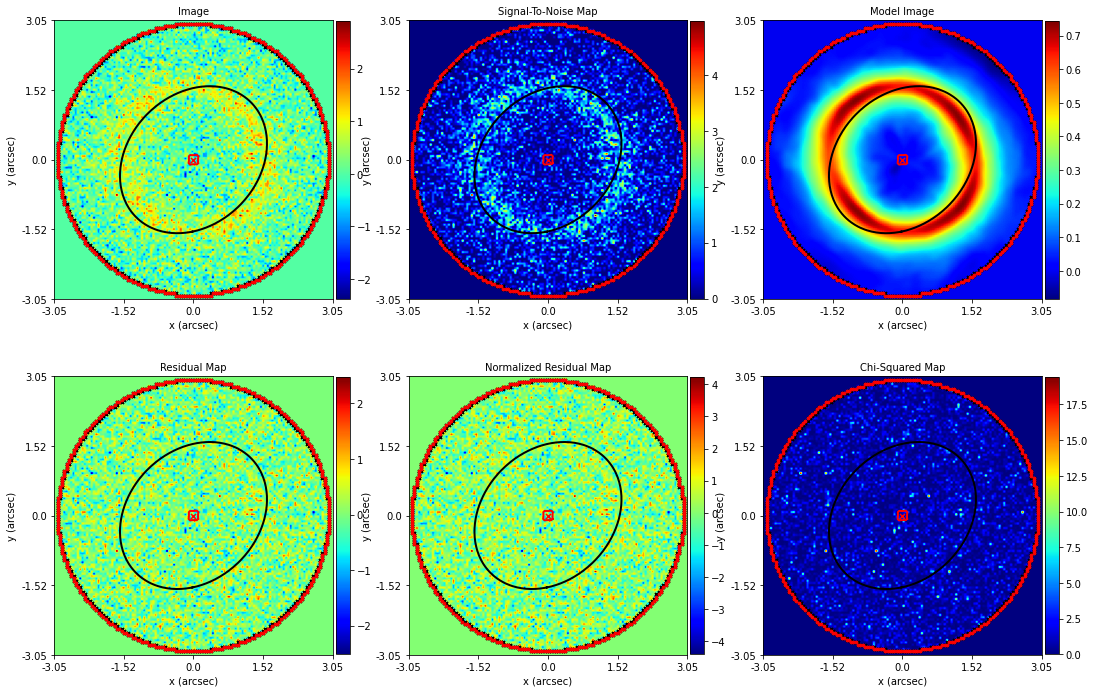

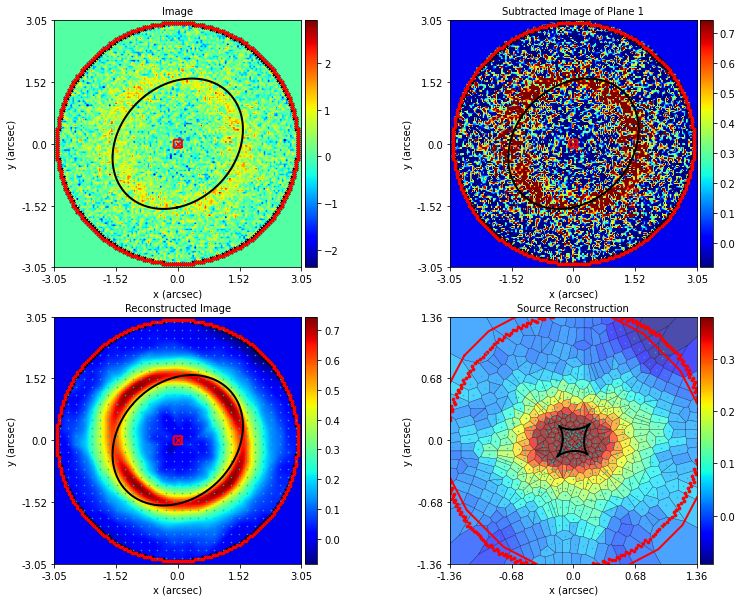

-10023.28902713651


In [7]:
fit_flat = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_flat, mask=mask, coefficient=9.2
)

include_2d = aplt.Include2D(mapper_data_pixelization_grid=True, mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit_flat, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)


print(fit_flat.log_evidence)

The fit was *excellent*. There were effectively no residuals in the fit, and the source has been reconstructed using 
lots of pixels! Nice!

Now, lets fit the next source, which is more compact.

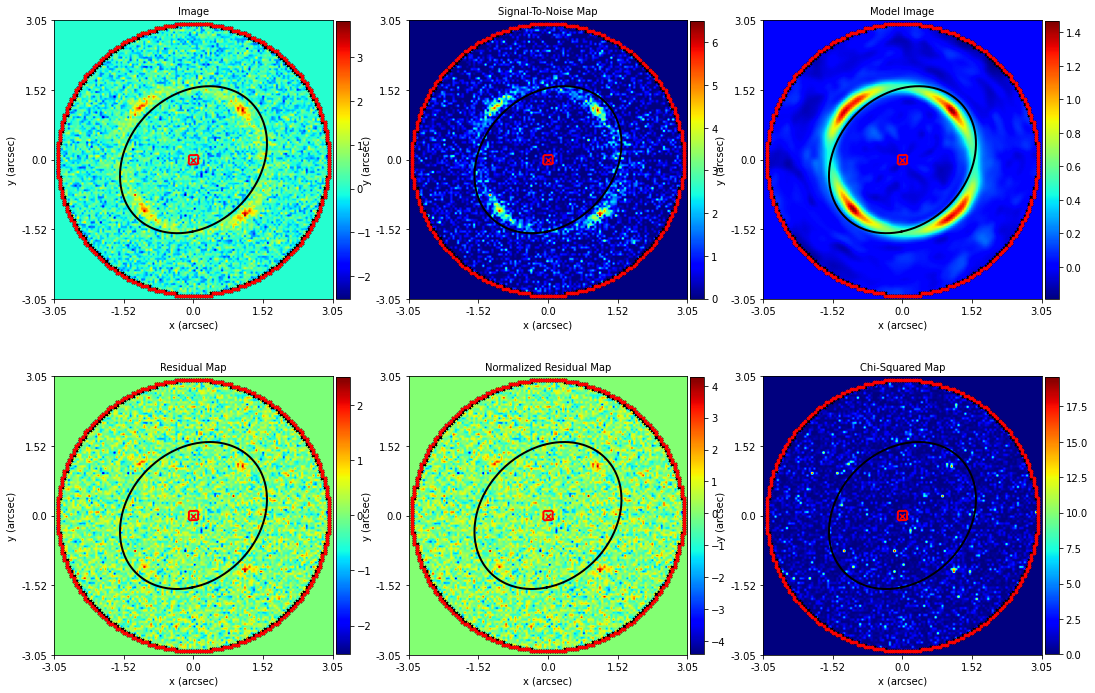

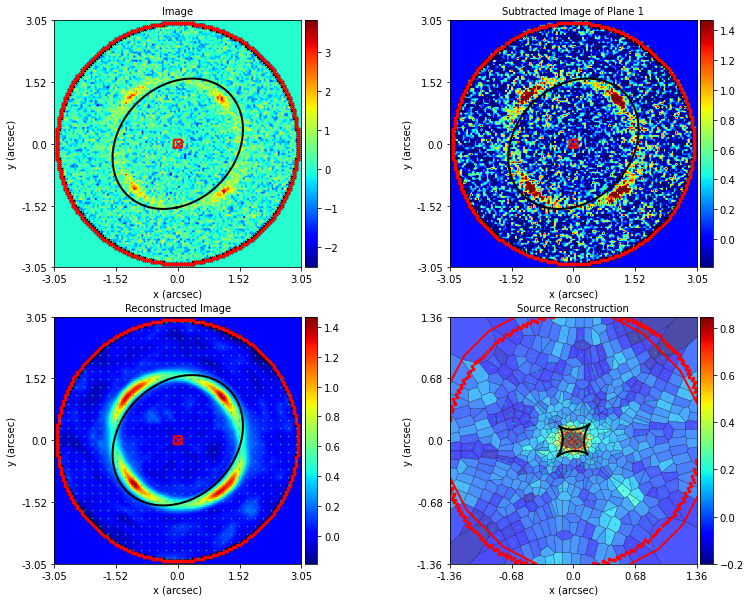

-10092.018283035031


In [8]:
fit_compact = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_compact, mask=mask, coefficient=3.3
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit_compact, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print(fit_compact.log_evidence)

Oh no! The fit does not look so good! Sure, we reconstruct *most* of the lensed source's structure, but there are two 
clear `blobs` in the residual-map where we are failing to reconstruct the central regions of the source galaxy.

Take a second to think about why this might be. Is it the pixelization or how the regularization is applying smoothing?

Finally, lets fit the very compact source. Given that the results for the compact source didn`t look so good, you`d 
be right in assuming this is just going to make things even worse. Again, think about why this might be.

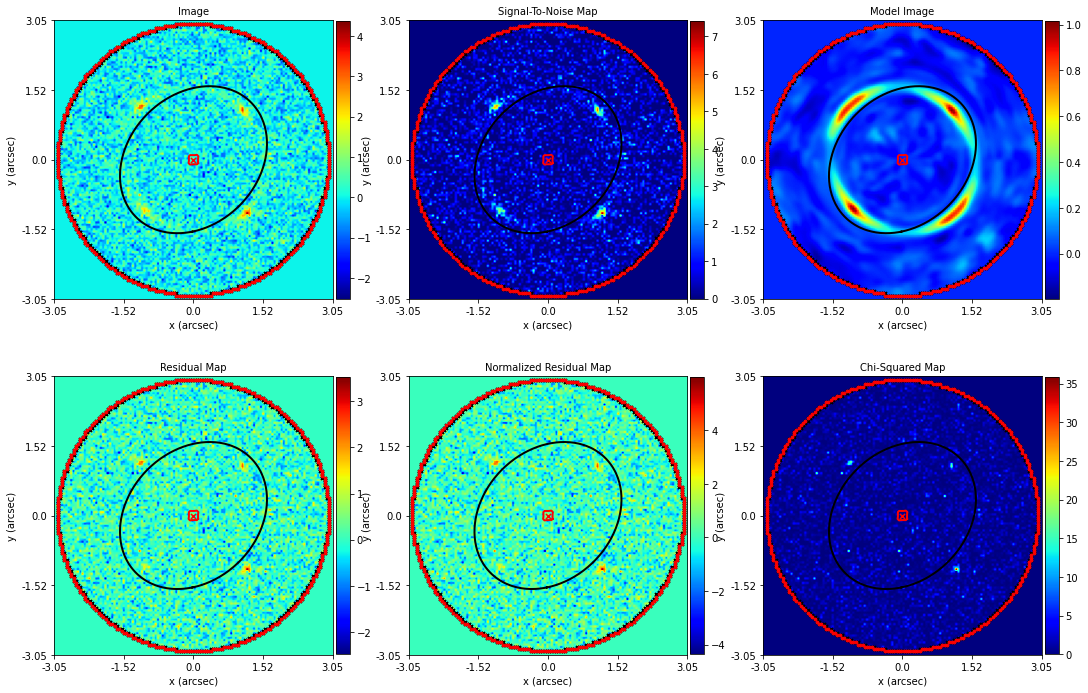

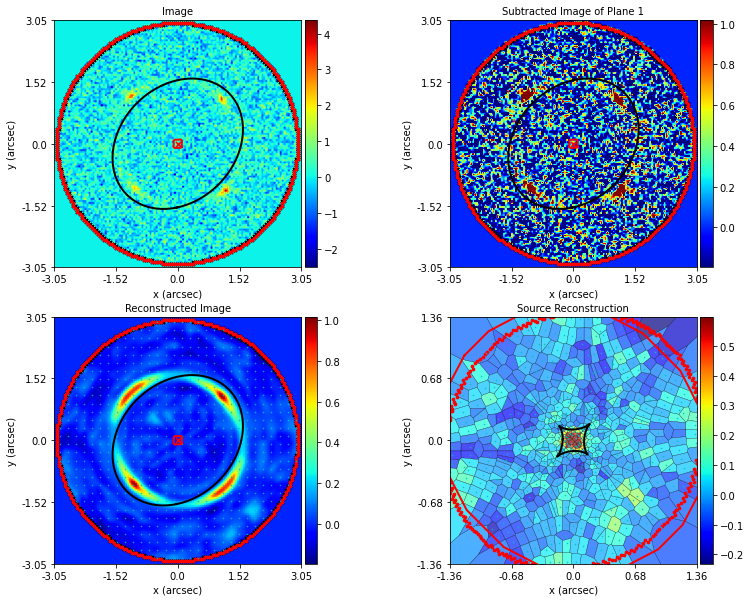

-10105.550743600445


In [9]:
fit_super_compact = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_super_compact, mask=mask, coefficient=3.1
)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=fit_super_compact, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print(fit_super_compact.log_evidence)

__Discussion__

Okay, so what did we learn? The more compact our source, the worse the fit. This happens even though we are using the 
*correct* lens mass model, telling us that something is going fundamentally wrong with our source reconstruction and 
inversion. Both the pixelization and regularization are to blame!

*Pixelization*:

The problem is the same one we found when we compared the `Rectangular` and `VoronoiMagnification` pixelizations in 
chapter 4. We are simply not dedicating enough source-pixels to the central regions of the source reconstruction, 
e.g. where it`s brightest. As the source becomes more compact, the source reconstruction no longer has enough 
resolution to resolve its fine-detailed central structure, causing the fit to the image to degrade.

Think about it, as we made our sources more compact we go from reconstructing them using ~100 source pixels, to ~20 
source pixels to ~ 10 source pixels. This is why we advocated not using the `Rectangular` pixelization in the previous 
chapter!

It turns out that adapting to the magnification wasn`t the best idea all along. As we simulated more compact sources 
the magnification (which is determined via the mass model) did not change. So, we foolishly reconstructed each source
using fewer and fewer pixels, leading to a worse and worse fit! Furthermore, these source's happened to be located in 
the highest magnification regions of the source plane! If the source's were further away from the centre of the 
caustic, the pixelization would use *even less* pixels to reconstruct it. That is NOT what we want!

**Regularization**:

Regularization also causes problems. When using a `Constant` regularization scheme, we regularize the source by 
adding up the difference in fluxes between all source-pixels multiplied by one single value, the regularization
coefficient. This means that, every single source pixel receives the same `level` of regularization, regardless of 
whether it is reconstructing the bright central regions of the source or its faint exterior regions. 

To visualize this, we are going to plot the `regularization_weights`. The `FitImagingPlotter` does not have a
method that is able to plot this attribute of the `Inversion`. However, the `FitImagingPlotter` has its own 
`InversionPlotter` which we can use to make this plot. The benefit of using this is that it inherits from the
`FitImagingPlotter` properties like the caustics, so they appear on the figure (this would not happen if we manually 
set up an `InversionPlotter` as we did in previous tutorials.

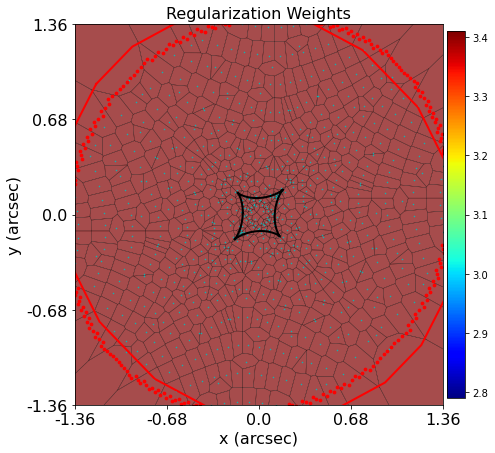

In [10]:
inversion_plotter = fit_imaging_plotter.inversion_plotter_of_plane(plane_index=1)
inversion_plotter.figures_2d(regularization_weights=True)

As you can see, all pixels are regularized with our input regularization_coefficient value of 3.6.

Is this the best way to regularize the source? Well, it isn't. But why not? Its 
because different regions of the source demand different levels of regularization:

 1) In the source's central regions its flux gradient is steepest; the change in flux between two source pixels is 
 much larger than in the exterior regions where the gradient is flatter (or there is no source flux at all). To 
 reconstruct the detailed structure of the source's cuspy inner regions, the regularization coefficient needs to 
 be much lower to avoid over-smoothing.

 2) On the flip side, the source reconstruction wants to assume a high regularization coefficient further out 
 because the source's flux gradient is flat (or there is no source signal at all). Higher regularization coefficients 
 will increase the Bayesian evidence because by smoothing more source-pixels it makes the solution `simpler`, given 
 that correlating the flux in these source pixels the solution effectively uses fewer source-pixels (e.g. degrees of 
 freedom).

So, herein lies the pitfall of a constant regularization scheme. Some parts of the reconstructed source demand a 
low regularization coefficient whereas other parts want a high value. Unfortunately, we end up with an intermediate 
regularization coefficient that over-smooths the source's central regions whilst failing to fully correlate exterior 
pixels. Thus, by using an adaptive regularization scheme, new solutions that further increase the Bayesian evidence 
become accessible.

**Noise Map**:

Before we wrap up this tutorial, I want us to also consider the role of our noise-map and get you thinking about 
why we might want to scale its variances. Lets look at the super-compact fit again;

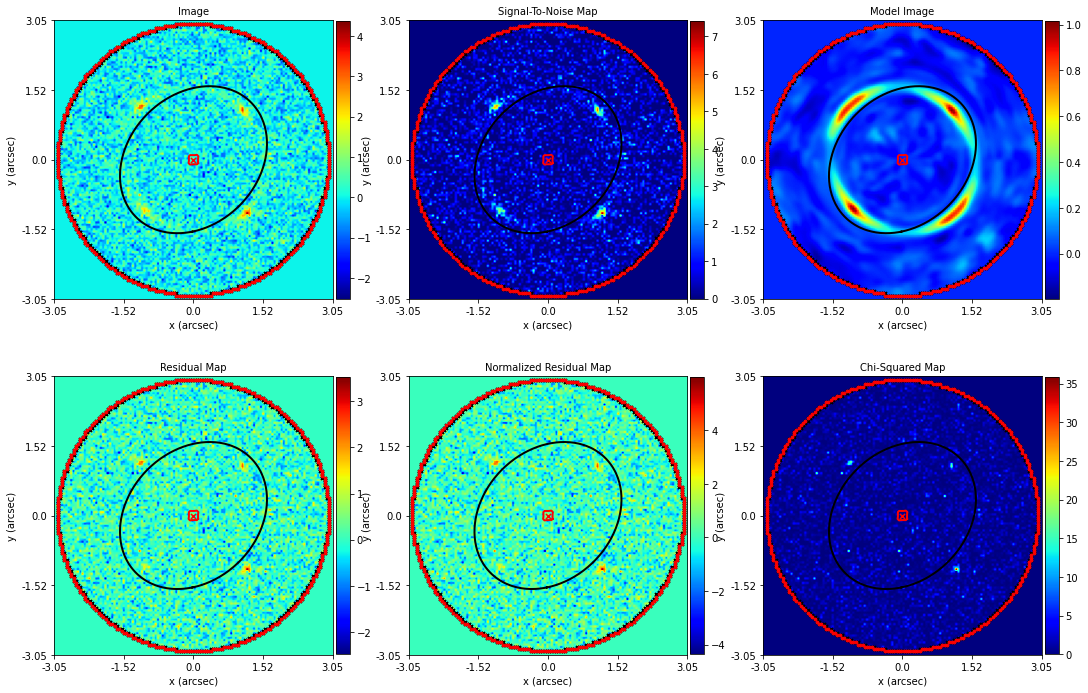

In [11]:
fit_imaging_plotter.subplot_fit_imaging()

So, whats the problem? Look closely at the `chi-squared image`. Here, you'll note that a small subset of our data 
have extremely large chi-squared values. This means our non-linear search (which is trying minimize chi-squared) is 
going to seek solutions which primarily only reduce these chi-squared values. For the image above a small subset of 
the data (e.g. < 5% of pixels) contributes to the majority of the log likelihood (e.g. > 95% of the overall chi-squared). 
This is *not* what we want, as instead of using the entire surface brightness profile of the lensed source galaxy to 
fit our lens model, we end up using only a small subset of its brightest pixels.

In the context of the Bayesian log evidence things become even more problematic. The Bayesian log evidence is trying to 
achieve a well-defined solution; a solution that provides a reduced chi-squared of 1. This solution is poorly defined 
when the chi-squared image looks like the one above. When a subset of pixels have chi-squareds > 300, the only way 
to achieve a reduced chi-squared 1 is to reduce the chi-squareds of other pixels to 0, e.g. by over-fitting their 
noise. Thus, we quickly end up in a regime where the choice of regularization_coefficient is ill defined.

With that, we have motivated hyper-mode. To put it simply, if we don't adapt our pixelization, regularization and 
noise-map, we will get solutions which reconstruct the source poorly, regularize the source sub-optimally and 
over-fit a small sub-set of image pixels. Clearly, we want adaptive pixelizations, regularization and noise-maps, which 
what we'll cover in this chapter!